In [1]:
!nvidia-smi

Fri Apr 22 04:44:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
#设置路径
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [3]:
! pip install transformers==4.0.1

     |████████████████████████████████| 1.4 MB 27.2 MB/s 
     |████████████████████████████████| 895 kB 61.6 MB/s 
     |████████████████████████████████| 2.9 MB 54.5 MB/s 


In [4]:
! pip install torch==1.4.0

     |████████████████████████████████| 753.4 MB 6.4 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [5]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

config = {
    'train_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/train.json',
    'dev_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/dev.json',
    'test_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/test.json',
    'embedding_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/sgns.weibo.word.bz2',
    'train_val_ratio':0.1,
    'vocab_size':30000,
    'batch_size':64,
    # 从后面可以看出 64能容纳99%的句子长度
    'max_seq_len':64,
    'num_epochs':1,
    'learning_rate':2e-5,
    'logging_step':500,
    'seed':2022
}

config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  return seed

seed_everything(config['seed'])

2022

In [6]:
import json
def read_data(path):
  sentence_a = []
  sentence_b = []
  labels = []
  with open(path, 'r', encoding='utf8') as f:
    for line in tqdm(f.readlines(), desc='Reading data'):
      line = json.loads(line)
      sentence_a.append(line['sentence1'])
      sentence_b.append(line['sentence2'])
      labels.append(int(line['label']))
  
  df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a','text_b','labels'])
  return df

In [7]:
# 复习一下zip函数:
# 这里有两个元组()，每个元组有两个句子，一个label
datas = [([1,2,3],[4,5,6],1),([777,888,999],[321,543,654],0)]
# 取出列表中每个元素（元组）
print(*datas)
print(zip(*datas))
# 把 datas 中的同一类别的放在一起
print(list(zip(*datas)))

([1, 2, 3], [4, 5, 6], 1) ([777, 888, 999], [321, 543, 654], 0)
[([1, 2, 3], [777, 888, 999]), ([4, 5, 6], [321, 543, 654]), (1, 0)]


In [8]:
train_df = read_data(config['train_file_path'])

Reading data: 100%|██████████| 34334/34334 [00:00<00:00, 249849.90it/s]


In [9]:
train_df.head()

,text_a,text_b,labels
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [10]:
dev_df = read_data(config['dev_file_path'])

Reading data: 100%|██████████| 4316/4316 [00:00<00:00, 250805.18it/s]


In [11]:
dev_df.head()

,text_a,text_b,labels
0,双十一花呗提额在哪,里可以提花呗额度,0
1,花呗支持高铁票支付吗,为什么友付宝不支持花呗付款,0
2,我的蚂蚁花呗支付金额怎么会有限制,我到支付宝实体店消费用花呗支付受金额限制,1
3,为什么有花呗额度不能分期付款,花呗分期额度不足,0
4,赠品不能设置用花呗付款,怎么不能花呗分期付款,0


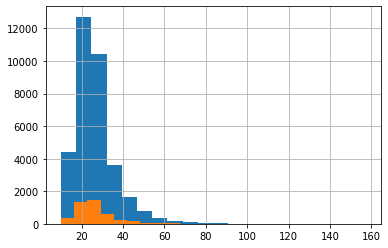

In [12]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).hist(bins = 20);
(dev_df.text_a.str.len() + dev_df.text_b.str.len()).hist(bins = 20);

In [13]:
# 64能容纳99%的句子长度
(train_df.text_a.str.len() + train_df.text_b.str.len()).quantile(0.99)

64.0

In [14]:
# 处理文件，生层词表放回关于train_df[train.json + dev.json],test_df
from collections import Counter
import jieba
import bz2
def preprocess(config):
  def convert2df(file_path, dataset='train'):
    sentence_a = []
    sentence_b = []
    labels = []
    with open(file_path, 'r', encoding='utf8') as f:
      for line in tqdm(f.readlines(), desc=f'Reading {dataset} data'):
        line = json.loads(line)
        sentence_a.append(line['sentence1'])
        sentence_b.append(line['sentence2'])
        if dataset != 'test':
          labels.append(int(line['label']))
        else:
          labels.append(0)
        # tokens为每次新加入的句子
        tokens = list(jieba.cut(sentence_a[-1])) + list(jieba.cut(sentence_b[-1])) 
        # print('tokens:',tokens)
        # tokens: ['蚂蚁', '花', '呗', '说', '我', '违约', '一次', '蚂蚁', '花', '呗', '违约', '行为', '是', '什么']
        token_counter.update(tokens)
    df = pd.DataFrame(zip(sentence_a,sentence_b,labels),columns=['text_a','text_b','labels'])
    return df
  
  token_counter = Counter()

  train_df = convert2df(config['train_file_path'],'train')
  dev_df = convert2df(config['dev_file_path'],'dev')
  test_df = convert2df(config['test_file_path'],'test')

  train_df = train_df.append(dev_df)
  vocab = set(token for token, _ in token_counter.most_common(config['vocab_size']))
  # print('vocab:',vocab)
  # vocab: {'城', '帮不上', '百度', '钱分', '会加分', '我晚', '手机短信'.......}
  return train_df, test_df, vocab



In [15]:
train_df, test_df, vocab = preprocess(config)

Reading train data:   0%|          | 0/34334 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.966 seconds.
Prefix dict has been built successfully.
Reading test data: 100%|██████████| 3861/3861 [00:02<00:00, 1902.41it/s]


In [16]:
# TextCNN 词表对应成向量
def get_embedding(vocab, embedding_file_path):
  print('processing embedding file, please wait...')

  token2embedding = {}

  with bz2.open(embedding_file_path) as f:
    token_vectors = f.readlines()
    # print('token_vectors:',list(token_vectors[0:10]))
    # token_vectors: [b'195202 300\n', b'\xef\xbc\x8c 0.094386 -0.200944 -0.030828 0.277130 ... 0.126182 -0.554329 -0.328050 \n', b'......\n'...]
    meta_info = token_vectors[0].split()
    # print('meta_info:',meta_info)
    # meta_info: [b'195202', b'300']
    print(f'{meta_info[0]} tokens in embedding file in total, vector size is {meta_info[-1]}')

    for line in tqdm(token_vectors[1:]):
      line = line.split()
      token = line[0].decode('utf8')
      # print('token:',token)
      # token: ！
      # token: 可以
      # token: 等
      # ...
      vector = line[1:]
      if token in vocab:
        token2embedding[token] = [float(num) for num in vector]
        # print('token2embedding[token]:',token2embedding[token])
        # token2embedding[token]: [-0.124044, -0.053688, 0.157958, ... -0.127075, -0.020528, 0.032646]
  #从4开始
  token2idx = {token: idx for idx, token in enumerate(token2embedding.keys(),4)}
  UNK, PAD, BOS, EOS = '<unk>', '<pad>', '<bos>', '<eos>'
  token2idx[PAD] = 0 
  token2idx[UNK] = 1
  token2idx[BOS] = 2
  token2idx[EOS] = 3
  idx2token = {idx: token for token, idx in token2idx.items()}
  idx2embedding = {token2idx[token]: embedding for token, embedding in token2embedding.items()}

  idx2embedding[0] = [.0] * int(meta_info[-1])
  idx2embedding[1] = [.0] * int(meta_info[-1])
  idx2embedding[2] = np.random.random(int(meta_info[-1])).tolist()
  idx2embedding[3] = np.random.random(int(meta_info[-1])).tolist()
  emb_mat = [idx2embedding[idx] for idx in range(len(idx2embedding))]

  return torch.tensor(emb_mat, dtype=torch.float), token2idx, len(vocab) + 4

In [17]:
embedding_matrix, token2idx, config['vocab_size'] = get_embedding(vocab, config['embedding_file_path'])

processing embedding file, please wait...
b'195202' tokens in embedding file in total, vector size is b'300'


100%|██████████| 195202/195202 [00:02<00:00, 66453.71it/s]


In [18]:
from collections import defaultdict
def tokenizer(sent, token2id):
  # .get() 找到返回 token的id, 没找到就返回 1 1->UNK
  ids = [token2id.get(token, 1) for token in jieba.cut(sent)]
  return ids

```
df = pd.DataFrame(np.random.randn(4, 3), columns = ['col1', 'col2', 'col3'])
df

	col1	  col2	   col3
0	0.956880	0.787811	0.099237
1	0.413166	-0.541869	0.548336
2	0.951179	0.113981	1.130187
3	0.802346	1.953860	-2.062042

for i, row in df.iterrows():
  print('i:',i,'row:',row)

i: 0 row: col1    0.956880
col2    0.787811
col3    0.099237
Name: 0, dtype: float64
i: 1 row: col1    0.413166
col2   -0.541869
col3    0.548336
Name: 1, dtype: float64
i: 2 row: col1    0.951179
col2    0.113981
col3    1.130187
Name: 2, dtype: float64
i: 3 row: col1    0.802346
col2    1.953860
col3   -2.062042
Name: 3, dtype: float64

for i, row in df.iterrows():
  print('row[0]:',row[0])

row[0]: 0.9568798249976214
row[0]: 0.41316597459220283
row[0]: 0.9511794577235149
row[0]: 0.8023455023210482
```

In [19]:
def read_data(data_df, train_val_ratio, token2id, mode = 'train'):
  if mode == 'train':
    X_train, y_train = defaultdict(list),[]
    X_val, y_val = defaultdict(list),[]
    num_val = int(len(data_df) * train_val_ratio)
  else:
    X_test, y_test = defaultdict(list),[]
  
  for i, row in tqdm(data_df.iterrows(), desc=f'Preprocessing {mode} data', total = len(data_df)):
    text_left = row[0]
    text_right = row[1]
    label = row[2]

    input_a = tokenizer(text_left, token2id = token2idx)
    input_b = tokenizer(text_right, token2id = token2idx)
    
    if mode == 'train':
      if i<num_val:
        X_val['text_left'].append(input_a)
        X_val['text_right'].append(input_b)
        y_val.append(label)
      else:
        X_train['text_left'].append(input_a)
        X_train['text_right'].append(input_b)
        y_train.append(label)
    else:
      X_test['text_left'].append(input_a)
      X_test['text_right'].append(input_b)
      y_test.append(label)

  if mode == 'train':
    label2id = {label : i for i,label in enumerate(np.unique(y_train))}
    id2label = {i : label for label, i in label2id.items()}
    y_train = torch.tensor([label2id[label] for label in y_train], dtype= torch.long)
    y_val = torch.tensor([label2id[label] for label in y_val], dtype= torch.long)
    return X_train, y_train, X_val, y_val, label2id, id2label
  else:
    y_test = torch.tensor(y_test, dtype=torch.long)
    return X_test, y_test

In [20]:
X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], token2idx, mode='train')
X_test, y_test = read_data(test_df, config['train_val_ratio'], token2idx, mode='test')

Preprocessing test data: 100%|██████████| 3861/3861 [00:00<00:00, 4198.39it/s]


In [21]:
from torch.utils.data import Dataset
class AFQMCDataset(Dataset):
  def __init__(self, x, y):
    super(AFQMCDataset, self).__init__()
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    data = (self.x['text_left'][idx],
         self.x['text_right'][idx],
         self.y[idx]   
            )
    return data
  
  def __len__(self):
    return self.y.size(0)#行数

```
TextCNN中collete_fn函数
def collete_fn(examples):
    input_ids_list = []
    labels =[]
    for example in examples:
        input_ids_list.append(example['input_ids'])
        labels.append(example['label'])

    # 对齐操作 -- 找到 input_ids_list 中 最长的 句子， 执行短句子补齐
    # 1. 找到 input_ids_list 中 最长的 句子
    max_length = max(len(input_ids) for input_ids in input_ids_list) 
    # 2. 定义一个 input_ids_tensor, 我们要把 每个 input_ids 放入 tensor 中
    input_ids_tensor = torch.zeros((len(labels), max_length), dtype=torch.long)
    for i, input_ids in enumerate(input_ids_list):
        # 得到当前句子的长度
        seq_len = len(input_ids)
        # 第i个句子，填充 seq_len 这么长
        input_ids_tensor[i, :seq_len] = torch.tensor(input_ids, dtype=torch.long)

    return {
        'input_ids' : input_ids_tensor,
        'labels' : torch.tensor(labels, dtype=torch.long)
    }
```

In [22]:
# __call__方法的调用
class MyClass():
  def __call__(self):
    print('__call__方法被调用')
    return 'done'

In [23]:
# 类实例化
obj = MyClass()

In [24]:
# 实例化的对象 当作函数用
res = obj()

__call__方法被调用


In [25]:
# 从 AFQMCDataset 输出的 data  = (sentence1, sentence2, label])
# 1. 将元组中属于sentence1的放在一起，属于sentence2的放在一起，属于label的放在一起
# 2. 对齐操作，找到sentence1, sentence2,最长的句子，执行短句子补齐
# 3. 定义一个tensor，把数据放里面

class Collator:
  def __init__(self, max_seq_len):
    self.max_seq_len = max_seq_len
  
  def get_max_seq_len(self, ids_list):
    cur_max_seq_len = max(len(input_id) for input_id in ids_list)
    max_seq_len = min (self.max_seq_len, cur_max_seq_len)
    return max_seq_len

  #当某个方法不需要用到对象中的任何资源(没有self),将这个方法改为一个静态方法, 加一个@staticmethod。
  #加上之后, 这个方法就和普通的函数没有什么区别了, 只不过写在了一个类中, 可以使用这个类的对象调用,
  @staticmethod
  def pad_and_truncate(text_ids_list, max_seq_len):
    input_ids = torch.zeros((len(text_ids_list), max_seq_len),dtype=torch.long)
    for i, text_ids in enumerate(text_ids_list):
      seq_len = min(len(text_ids), max_seq_len)
      input_ids[i, :seq_len] = torch.tensor(text_ids[:seq_len],dtype=torch.long)
    return input_ids

  def __call__(self, examples):
    # 1. 将元组中属于sentence1的放在一起，属于sentence2的放在一起，属于label的放在一起
    text_ids_left_list, text_ids_right_list, labels_list = list(zip(*examples))
    # 2.1 找到 text_ids_left_list, text_ids_right_list 最长的句子长度
    max_text_left_length = self.get_max_seq_len(text_ids_left_list)
    max_text_right_length = self.get_max_seq_len(text_ids_right_list)

    # 2.2 执行短句子补齐, 3.定义一个tensor，把数据放里面
    text_left_ids = self.pad_and_truncate(text_ids_left_list, max_text_left_length)
    text_right_ids = self.pad_and_truncate(text_ids_right_list, max_text_right_length)
    labels = torch.tensor(labels_list, dtype = torch.long)

    data_list = [text_left_ids, text_right_ids, labels]
    return data_list

In [26]:
from torch.utils.data import DataLoader
def build_dataloader(train_df, test_df, config, vocab):
  X_train, y_train ,X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], vocab, mode='train')
  X_test, y_test = read_data(test_df, config['train_val_ratio'], vocab, mode='test')

  train_dataset = AFQMCDataset(X_train, y_train)
  val_dataset = AFQMCDataset(X_val, y_val)
  test_dataset = AFQMCDataset(X_test, y_test)
  
  collate_fn = Collator(config['max_seq_len'])

  train_dataloader = DataLoader(dataset = train_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = True, collate_fn = collate_fn)
  val_dataloader = DataLoader(dataset = val_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = False, collate_fn = collate_fn)
  test_dataloader = DataLoader(dataset = test_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = False, collate_fn = collate_fn)

  return id2label, test_dataloader, val_dataloader, train_dataloader

In [27]:
id2label, test_dataloader, val_dataloader, train_dataloader = build_dataloader(train_df, test_df, config, token2idx)

Preprocessing test data: 100%|██████████| 3861/3861 [00:00<00:00, 4147.49it/s]


In [28]:
for i in train_dataloader:
  print('dataloader中一个batch数据为（左+右+label）:',i)
  break

dataloader中一个batch数据为（左+右+label）: [tensor([[ 272, 1359,  410,  ...,    0,    0,    0],
        [2493, 1448, 1359,  ...,    0,    0,    0],
        [ 190, 1412,   22,  ...,    0,    0,    0],
        ...,
        [2095,  189, 1226,  ...,    0,    0,    0],
        [ 925,  981,  407,  ...,    0,    0,    0],
        [2493, 1448, 1359,  ...,    0,    0,    0]]), tensor([[ 410,  272, 1359,  ...,    0,    0,    0],
        [2493, 1448, 1359,  ...,    0,    0,    0],
        [  22,    5, 1448,  ...,    0,    0,    0],
        ...,
        [  22,    5,  272,  ...,    0,    0,    0],
        [ 272, 1359,  925,  ...,    0,    0,    0],
        [ 410,  130, 1448,  ..., 1090,   21,   69]]), tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])]


In [29]:
val_iterator = tqdm(val_dataloader, desc='Test_item', total=len(val_dataloader))
for batch in val_iterator:
  print('batch:',batch)
  i=0
  for item in batch:
    print('item:',item)
  break

Test_item:   0%|          | 0/121 [00:00<?, ?it/s]

batch: [tensor([[2493, 1448, 1359,  ...,    0,    0,    0],
        [2493,  272, 1359,  ...,    0,    0,    0],
        [ 407,   22,   70,  ...,    0,    0,    0],
        ...,
        [ 272, 1359,  607,  ...,    0,    0,    0],
        [   1, 1359,   16,  ...,    0,    0,    0],
        [ 272, 1359, 4406,  ...,    0,    0,    0]]), tensor([[1448, 1359,   15,  ...,    0,    0,    0],
        [2493,  272, 1359,  ...,    0,    0,    0],
        [ 111,   69,  272,  ...,    0,    0,    0],
        ...,
        [1090, 1090, 1090,  ...,    0,    0,    0],
        [   1,  272, 1359,  ...,  703,   38,    0],
        [ 272, 1359,  272,  ...,    0,    0,    0]]), tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
item: tensor([[2493, 1448, 1359,  ...,    0,    0,    0],
        [2493,  272, 1359,  ...,    0,    0,    0],
        [ 

In [30]:
from sklearn.metrics import f1_score, accuracy_score
def evaluation(config, model, val_dataloader):
  model.eval()
  preds = []
  labels = []
  val_loss = 0.
  val_iterator = tqdm(val_dataloader, desc='Evaluation', total=len(val_dataloader))
  with torch.no_grad():
    for batch in val_iterator:
      labels.append(batch[-1])
      batch = [item.to(config['device']) for item in batch]
      loss, logits = model(batch)[:2]

      val_loss += loss.item()
      # 返回逻辑值最大的位置，要么0，要么1
      preds.append(logits.argmax(dim=-1).detach().cpu())

  avg_val_loss = val_loss / len(val_dataloader)
  labels = torch.cat(labels, dim=0).numpy()
  preds = torch.cat(preds, dim=0).numpy()
  f1 = f1_score(labels, preds, average='macro')

  acc = accuracy_score(labels, preds)

  return avg_val_loss, f1, acc

In [31]:
from tqdm import trange
from transformers import AdamW

def train(model, config, id2label, train_dataloader, val_dataloader):
  optimizer = AdamW(model.parameters(), lr = config['learning_rate'])
  epoch_iterator = trange(config['num_epochs'])

  global_steps = 0
  train_loss = 0.
  logging_loss = 0.

  for epoch in epoch_iterator:
    train_iterator = tqdm(train_dataloader, desc='Training', total=len(train_dataloader))
    model.train()
    for batch in train_iterator:

      batch =  [item.to(config['device']) for item in batch]
      loss = model(batch)[0]

      model.zero_grad()
      loss.backward()

      optimizer.step()

      train_loss += loss.item()
      global_steps += 1

      if global_steps % config['logging_step'] == 0:
        print_train_loss = (train_loss - logging_loss) / config['logging_step']
        logging_loss = train_loss

        avg_val_loss, f1, acc = evaluation(config, model, val_dataloader)

        print_log = f'>>>traing loss:{print_train_loss: .5f}, valid loss:{avg_val_loss: .5f}, valid f1 score:{f1: .5f}, valid acc:{acc: .5f}'

        print(print_log)
        model.train()
  return model

In [32]:
def predict(config, id2label, model, test_dataloader):
  test_iterator = tqdm(test_dataloader, desc='Predicting', total=len(test_dataloader))
  model.eval()
  test_preds = []
  with torch.no_grad():
    for batch in test_iterator:
      batch = [item.to(config['device']) for item in batch]
      logits = model(batch)[1]
      test_preds.append(logits.argmax(dim=-1).detach().cpu())
  test_preds = torch.cat(test_preds, dim = 0).numpy()
  test_preds = [id2label[id_] for id_ in test_preds]
  return test_preds

# 预备知识

In [33]:
# 定义一个[2,3,4]的tensor -> [batch_size, seq_len, embedding_dim]  一个batch有两个句子，每个句子3个词，每个词的维度为4
a = torch.tensor([[[2., 2., 2., 2.],[3., 3., 3., 3.],[4., 4., 4., 4.]],[[5., 5., 5., 5.],[6., 6., 6., 6.],[7., 7., 7., 7.]]])
print(a)
print(a.size())

tensor([[[2., 2., 2., 2.],
         [3., 3., 3., 3.],
         [4., 4., 4., 4.]],

        [[5., 5., 5., 5.],
         [6., 6., 6., 6.],
         [7., 7., 7., 7.]]])
torch.Size([2, 3, 4])


In [34]:
# [2,1,4]的tensor
# torch.Tensor是一种包含单一数据类型元素的多维矩阵，torch.Tensor是默认的tensor类型（torch.FlaotTensor）的简称。
# torch.ByteTensor 是 CPU tensor, 8-bit integer (unsigned)
ones = torch.ByteTensor([[[1, 1, 0, 0]],[[0, 1, 1, 0]]])
print(ones.size())

torch.Size([2, 1, 4])


In [35]:
# 相当于将词向量某些维度清零
print(ones * a) # 首先，ones. 从[2,1,4] 变成 [2,3,4] （填充） 再与a中逐个元素相乘
print((ones * a).size())

tensor([[[2., 2., 0., 0.],
         [3., 3., 0., 0.],
         [4., 4., 0., 0.]],

        [[0., 5., 5., 0.],
         [0., 6., 6., 0.],
         [0., 7., 7., 0.]]])
torch.Size([2, 3, 4])


## masked fill 方法

In [36]:
# [2, 3, 1]
mask = torch.ByteTensor([[[1],[1],[0]],[[0],[1],[1]]])
print(mask)
print(mask.size())

tensor([[[1],
         [1],
         [0]],

        [[0],
         [1],
         [1]]], dtype=torch.uint8)
torch.Size([2, 3, 1])


```
a:
tensor([[[2., 2., 2., 2.],
    [3., 3., 3., 3.],
    [4., 4., 4., 4.]],

    [[5., 5., 5., 5.],
    [6., 6., 6., 6.],
    [7., 7., 7., 7.]]])

mask:
tensor([[[1],
    [1],
    [0]],

    [[0],
    [1],
    [1]]], dtype=torch.uint8)
```

In [37]:
# a [2,3,4] mask[2,3,1]
# 是将 mask 中 为1 的元素所在的索引，在 a 中 相同索引处替换为 value值
# 把某个词向量给mask掉
b = a.masked_fill(mask, value = torch.tensor(-1e7))
print(b)
print(b.size())

tensor([[[-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [ 4.0000e+00,  4.0000e+00,  4.0000e+00,  4.0000e+00]],

        [[ 5.0000e+00,  5.0000e+00,  5.0000e+00,  5.0000e+00],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07]]])
torch.Size([2, 3, 4])


/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:41: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


``` 
ones:
tensor([[[1, 1, 0, 0]],
    [[0, 1, 1, 0]]])
```

In [38]:
# 同理，可以用[2, 1, 4] mask掉 [2, 3, 4]
# 把 mask 改成 ones
mask = ones #[2, 1, 4]
b= a.masked_fill(mask, value = torch.tensor(-1e7))
print(b)
print(b.size())

tensor([[[-1.0000e+07, -1.0000e+07,  2.0000e+00,  2.0000e+00],
         [-1.0000e+07, -1.0000e+07,  3.0000e+00,  3.0000e+00],
         [-1.0000e+07, -1.0000e+07,  4.0000e+00,  4.0000e+00]],

        [[ 5.0000e+00, -1.0000e+07, -1.0000e+07,  5.0000e+00],
         [ 6.0000e+00, -1.0000e+07, -1.0000e+07,  6.0000e+00],
         [ 7.0000e+00, -1.0000e+07, -1.0000e+07,  7.0000e+00]]])
torch.Size([2, 3, 4])


/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:41: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


# ESIM 
## Enhanced LSTM for Natural Language Inference

In [39]:
model_config = {
    'embedding': embedding_matrix, #torch.Size([5251,300])
    'freeze_emb': True,
    'hidden_size': 256,
    'dropout': 0.3,
    'num_layers': 2,
    'concat_layers': True,
    'rnn_type': 'lstm',
    'num_labels': len(id2label)
}

### 一些参数
```
B: batch_size
L = 'inputs left'  sequence length
R = 'inputs right'  sequence length
D = embedding size
H = hidden size
```

In [40]:
import torch.nn as nn
class RNNDropout(nn.Dropout):
  # 将词向量 某些维度 清0
  # sequences_batch [B, L, D] (和query、doc一样)
  def forward(self, sequences_batch):
    # ones [B, D]
    ones = sequences_batch.data.new_ones(sequences_batch.shape[0], sequences_batch.shape[-1])
    # 随机mask ones
    # dropout_mask [B, D] ones后面是dropout API的参数  
    # p – probability of an element to be zeroed. Default: 0.5
    # training – apply dropout if is True. Default: True
    # inplace – If set to True, will do this operation in-place[将原地执行此操作]. Default: False
    dropout_mask = nn.functional.dropout(ones, self.p, self.training, inplace=False)
    # unsqueeze(1)增加一个维度
    return dropout_mask.unsqueeze(1) * sequences_batch


In [42]:
import torch.nn.functional as F
class StackedBRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers,
         dropout_rate = 0, dropout_output = False,
         rnn_type = nn.LSTM, concat_layers = False):
    
    super().__init__()
    self.dropout_output = dropout_output
    self.dropout_rate = dropout_rate
    self.num_layers = num_layers
    self.concat_layers = concat_layers
    self.rnns = nn.ModuleList()
    # 共有2层lstm
    for i in range(num_layers):
      input_size = input_size if i == 0 else 2*hidden_size
      self.rnns.append(rnn_type(input_size, hidden_size, num_layers=1, bidirectional=True))

    def forward(self, x):
      # x (B, L, D)[此时不能输入到LSTM中] -> (L, B, D)
      x= x.transpose(0, 1)
      outputs = [x]
      for i in range(self.num_layers):
        rnn_input = outputs[-1]

        if self.dropout_rate > 0:
          rnn_input = F.dropout(rnn_input, p=self.dropout_rate, training = self.training)


        # self.rnn[i](rnn_input) (output, (h_n, c_n))
        rnn_output = self.rnns[i](rnn_input)[0]
        outputs.append(rnn_output)
      # outputs [x, output0, output1]
      if self.concat_layers:
        output = torch.cat(outputs[1:], 2)
      else:
        output = outputs[-1]
      # output (L, B, D) -> (B, L, D)
      output = output.transpose(0, 1)

      if self.dropout_output and self.dropout_rate > 0:
        output = F.dropout(output, p = self.dropout_rate, training = self.training)
      
      # 进行 transpose之后，tensor在内存中不连续， contiguous将output内存连续
      return output.contiguous()